In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import LinearSVC

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
# load the data and take a peek
df = pd.read_csv("stroke_data.csv")
df.head()

,Stroke,NASCET,CALCVol,CALCVolProp,MATXVol,MATXVolProp,LRNCVol,LRNCVolProp,MaxCALCArea,MaxCALCAreaProp,...,WallVol,MaxStenosisByDiameter,age,sex,SmokingHistory,AtrialFibrillation,CoronaryArteryDisease,DiabetesHistory,HypercholesterolemiaHistory,HypertensionHistory
0,N,0,235.252599,0.070443,3156.834690,0.759958,224.871710,0.091085,12.350494,0.365768,...,4192.170353,10.544113,72,1,1,0,0,0,0,1
1,N,0,31.433595,0.016165,3032.860796,0.813306,368.560663,0.133989,7.130660,0.211247,...,3917.039836,18.646197,76,1,1,0,0,1,1,1
2,N,0,113.404823,0.038081,3835.220140,0.782526,321.158928,0.083037,16.286916,0.408811,...,4935.327463,19.735114,72,0,0,0,0,0,0,0
3,Y,0,780.823789,0.213432,3518.876937,0.761089,140.517346,0.032065,63.350869,0.576206,...,4909.503817,20.288317,61,1,1,0,0,1,1,1
4,N,0,84.055774,0.041384,2990.273268,0.749869,293.269922,0.075398,17.583561,0.321507,...,4045.053268,49.297050,65,1,0,0,0,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Stroke                       126 non-null    object 
 1   NASCET                       126 non-null    int64  
 2   CALCVol                      126 non-null    float64
 3   CALCVolProp                  126 non-null    float64
 4   MATXVol                      126 non-null    float64
 5   MATXVolProp                  126 non-null    float64
 6   LRNCVol                      126 non-null    float64
 7   LRNCVolProp                  126 non-null    float64
 8   MaxCALCArea                  126 non-null    float64
 9   MaxCALCAreaProp              126 non-null    float64
 10  MaxDilationByArea            126 non-null    float64
 11  MaxMATXArea                  126 non-null    float64
 12  MaxMATXAreaProp              126 non-null    float64
 13  MaxLRNCArea         

In [6]:
# select 30% to set aside, stratified by stroke
p = 0.3
# Super important to seed your random number generator for reproducibility
rng = np.random.default_rng(42) # yes, this is an over-used random number seed
n_test = int(p * len(df))
is_stroke = df["Stroke"] == "Y"
not_stroke = df["Stroke"] == "N"
n_stroke = int(p * is_stroke.sum())
test_ids = np.hstack([rng.choice(np.where(is_stroke)[0], n_stroke),
                     rng.choice(np.where(~is_stroke)[0], n_test - n_stroke)])
train_ids = np.setdiff1d(np.arange(len(df)), test_ids)
test = df.iloc[test_ids]
train = df.iloc[train_ids]

# re-define the is_stroke and not_stroke to relate to the training set
# Also cast to simple list to avoid pandas keyindex weirdness after pipeline
is_stroke = list(train["Stroke"] == "Y")
not_stroke = list(train["Stroke"] == "N")

In [7]:
# Verify the splits
print(pd.DataFrame([train.value_counts("Stroke"), test.value_counts("Stroke")], ["Train", "Test"]))

Stroke   N   Y
Train   46  46
Test    18  19


In [8]:
# explore the training data
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, 0 to 125
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Stroke                       92 non-null     object 
 1   NASCET                       92 non-null     int64  
 2   CALCVol                      92 non-null     float64
 3   CALCVolProp                  92 non-null     float64
 4   MATXVol                      92 non-null     float64
 5   MATXVolProp                  92 non-null     float64
 6   LRNCVol                      92 non-null     float64
 7   LRNCVolProp                  92 non-null     float64
 8   MaxCALCArea                  92 non-null     float64
 9   MaxCALCAreaProp              92 non-null     float64
 10  MaxDilationByArea            92 non-null     float64
 11  MaxMATXArea                  92 non-null     float64
 12  MaxMATXAreaProp              92 non-null     float64
 13  MaxLRNCArea               

In [9]:
# Group the imaging predictors and risk factors
VC_preds = ["CALCVol", "CALCVolProp", "MATXVol", "MATXVolProp", "LRNCVol", 
    "LRNCVolProp", "MaxCALCArea", "MaxCALCAreaProp", "MaxDilationByArea", 
    "MaxMATXArea", "MaxMATXAreaProp", "MaxLRNCArea", "MaxLRNCAreaProp", 
    "MaxMaxWallThickness", "MaxRemodelingRatio", "MaxStenosisByArea", 
    "MaxWallArea", "WallVol", "MaxStenosisByDiameter"]
risk_preds = ["age", "sex", "SmokingHistory", "AtrialFibrillation", "CoronaryArteryDisease", 
    "DiabetesHistory", "HypercholesterolemiaHistory", "HypertensionHistory"]

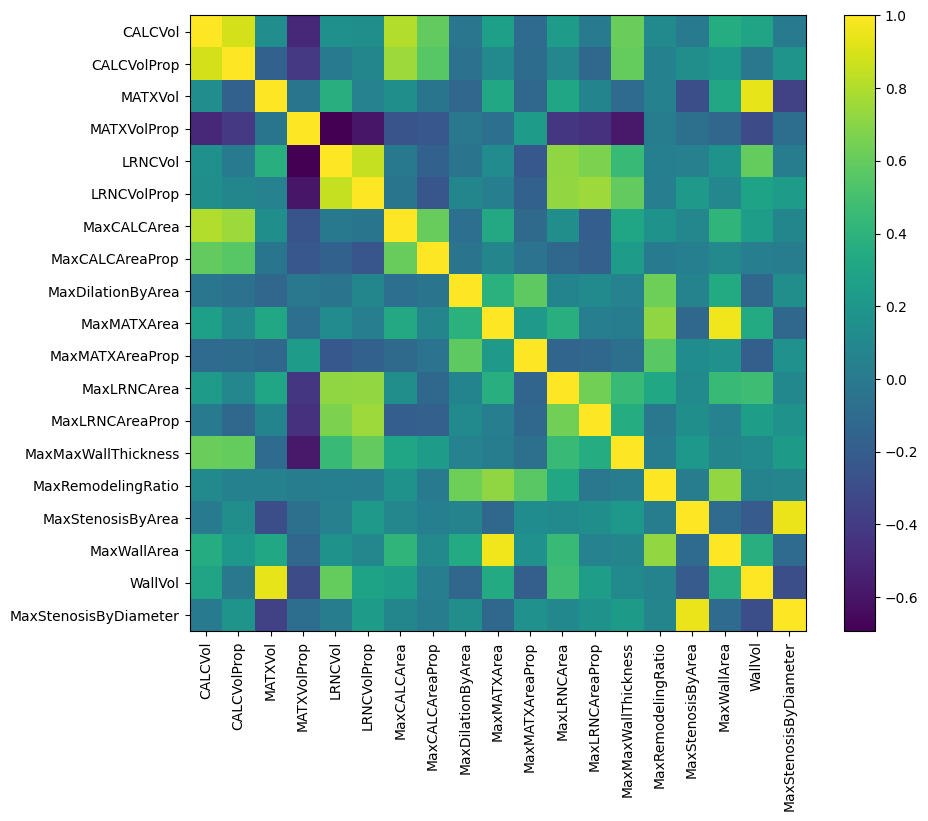

In [10]:
# Look at the correlation coefficients of the imaging predictors
im_corr = train[VC_preds].corr().values
plt.figure(figsize=(10,8))
plt.imshow(im_corr)
plt.colorbar()
plt.xticks(range(len(VC_preds)), VC_preds, rotation=90)
plt.yticks(range(len(VC_preds)), VC_preds)
plt.show()

array([[ 1.        , -0.01936225],
       [-0.01936225,  1.        ]])

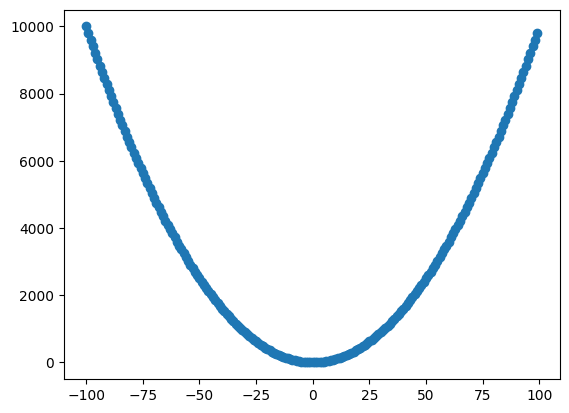

In [ ]:
# show that corrcoef only represents linear relationships
test_x = np.arange(-100,100)
test_y = test_x * test_x
plt.scatter(test_x, test_y)
np.corrcoef(test_x, test_y)

In [15]:
# print out features that are off-diagonal but have high correlation
corr_thresh  = 0.9
exclude = []
scatter_check = []
for i in range(len(VC_preds)):
    for j in range(len(VC_preds)):
        if i < j and abs(im_corr[i, j]) > corr_thresh:
            print(f"{VC_preds[i]} is correlated with {VC_preds[j]}")
            exclude.append(VC_preds[i])
            scatter_check += [VC_preds[i], VC_preds[j]]
            
# filter the VC_preds list
preds = [p for p in VC_preds if p not in exclude]

MATXVol is correlated with WallVol
MaxMATXArea is correlated with MaxWallArea
MaxStenosisByArea is correlated with MaxStenosisByDiameter


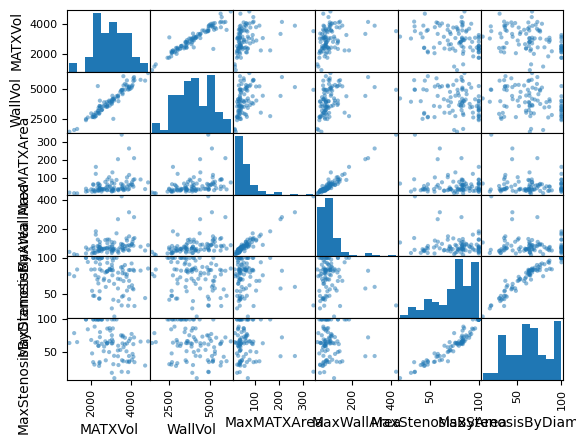

In [19]:
# look at a scatter matrix for the excluded features
scatter_matrix(train[scatter_check])#, diagonal='kde')
plt.show()

Text(0.5, 1.0, 'Maximum cross-sectional area of lipid-rich necrotic core')

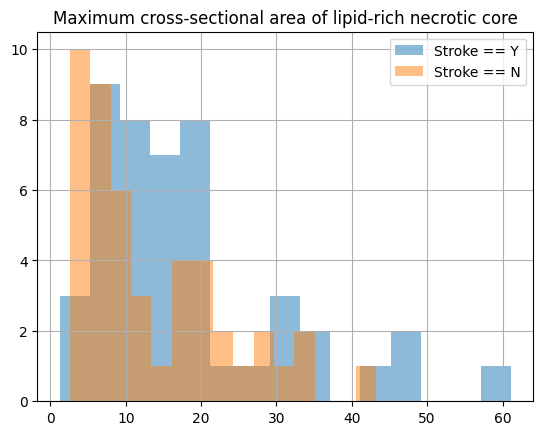

In [20]:
# look at the MaxLRNCArea
train[is_stroke]["MaxLRNCArea"].hist(bins=15, alpha=0.5)
train[not_stroke]["MaxLRNCArea"].hist(bins=15, alpha=0.5)
plt.legend(["Stroke == Y", "Stroke == N"])
plt.title("Maximum cross-sectional area of lipid-rich necrotic core")

Text(0.5, 1.0, 'Log of maximum cross-sectional area of lipid-rich necrotic core')

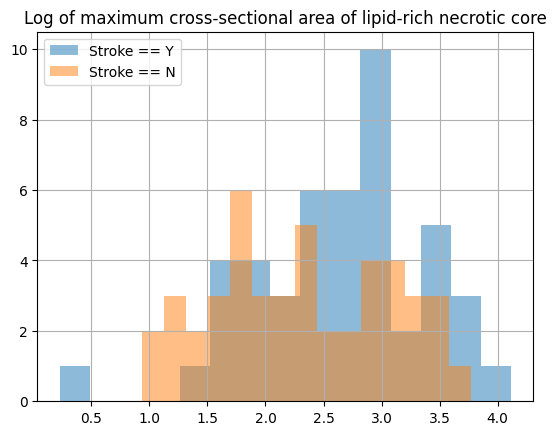

In [21]:
# transfrom MaxLRNCArea and re-do the histogram
t = train["MaxLRNCArea"].apply(lambda x: np.log(x))
t[is_stroke].hist(bins=15, alpha=0.5)
t[not_stroke].hist(bins=15, alpha=0.5)
plt.legend(["Stroke == Y", "Stroke == N"])
plt.title("Log of maximum cross-sectional area of lipid-rich necrotic core")

array([[<Axes: title={'center': 'CALCVol'}>,
        <Axes: title={'center': 'CALCVolProp'}>,
        <Axes: title={'center': 'MATXVolProp'}>,
        <Axes: title={'center': 'LRNCVol'}>],
       [<Axes: title={'center': 'LRNCVolProp'}>,
        <Axes: title={'center': 'MaxCALCArea'}>,
        <Axes: title={'center': 'MaxCALCAreaProp'}>,
        <Axes: title={'center': 'MaxDilationByArea'}>],
       [<Axes: title={'center': 'MaxMATXAreaProp'}>,
        <Axes: title={'center': 'MaxLRNCArea'}>,
        <Axes: title={'center': 'MaxLRNCAreaProp'}>,
        <Axes: title={'center': 'MaxMaxWallThickness'}>],
       [<Axes: title={'center': 'MaxRemodelingRatio'}>,
        <Axes: title={'center': 'MaxWallArea'}>,
        <Axes: title={'center': 'WallVol'}>,
        <Axes: title={'center': 'MaxStenosisByDiameter'}>]], dtype=object)

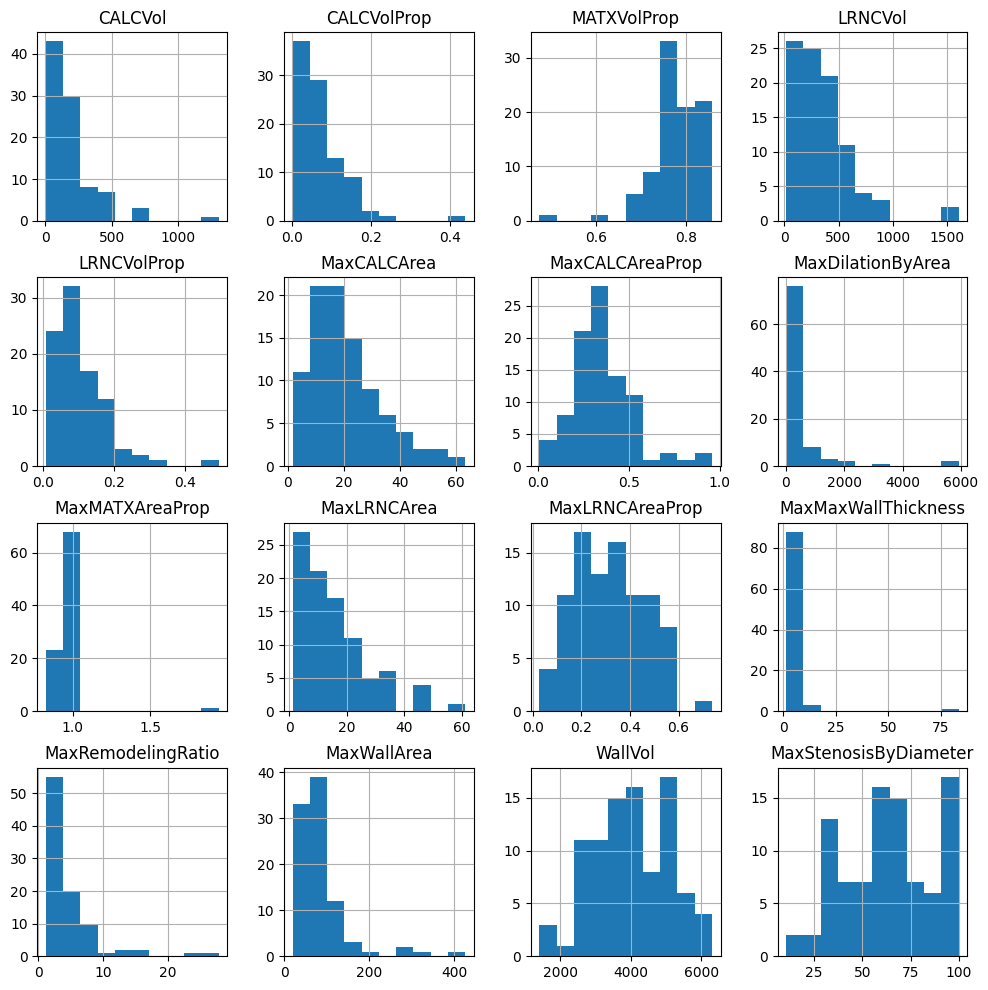

In [24]:
# Look at all the histograms
def plot_hists(preds, data):
    N = int(np.ceil(len(preds) ** 0.5))
    _,ax = plt.subplots(N,N,figsize=(12,12))
    for p, pred in enumerate(preds):
        row = p // N
        col = p % N
        ax[row][col].hist(data[pred], bins=15, alpha=0.5)
        ax[row][col].set_title(pred)

# plot_hists(preds, train)
# an easier way
train[preds].hist(figsize=(12,12))

In [25]:
# Create a pipeline to normalize, then look at the histogram again
# The power transformer also centres and normalizes
pipeline = Pipeline(steps=[("powertransform", PowerTransformer("yeo-johnson"))])
pipeline.fit(train[preds])
train_p = pd.DataFrame(pipeline.transform(train[preds]), columns=preds)

array([[<Axes: title={'center': 'CALCVol'}>,
        <Axes: title={'center': 'CALCVolProp'}>,
        <Axes: title={'center': 'MATXVolProp'}>,
        <Axes: title={'center': 'LRNCVol'}>],
       [<Axes: title={'center': 'LRNCVolProp'}>,
        <Axes: title={'center': 'MaxCALCArea'}>,
        <Axes: title={'center': 'MaxCALCAreaProp'}>,
        <Axes: title={'center': 'MaxDilationByArea'}>],
       [<Axes: title={'center': 'MaxMATXAreaProp'}>,
        <Axes: title={'center': 'MaxLRNCArea'}>,
        <Axes: title={'center': 'MaxLRNCAreaProp'}>,
        <Axes: title={'center': 'MaxMaxWallThickness'}>],
       [<Axes: title={'center': 'MaxRemodelingRatio'}>,
        <Axes: title={'center': 'MaxWallArea'}>,
        <Axes: title={'center': 'WallVol'}>,
        <Axes: title={'center': 'MaxStenosisByDiameter'}>]], dtype=object)

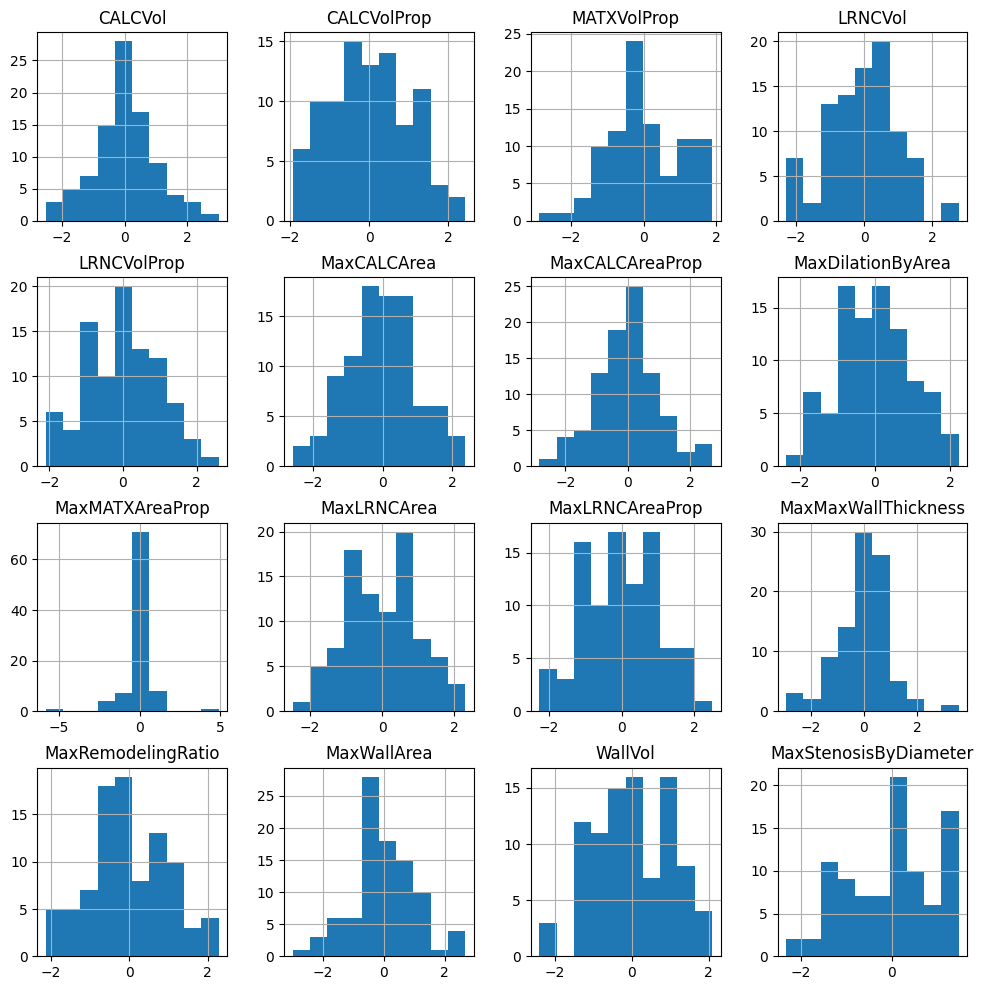

In [26]:
train_p[preds].hist(figsize=(12,12))

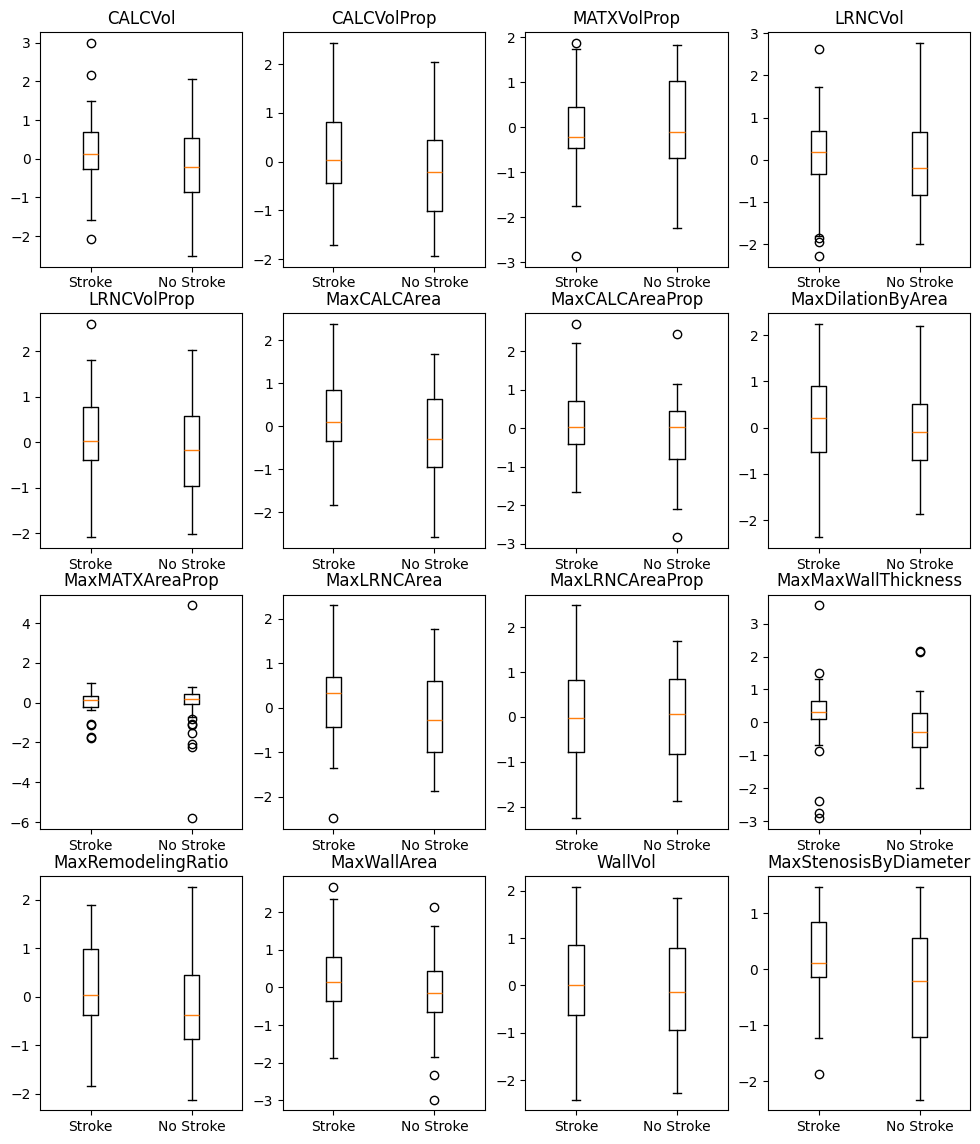

In [27]:
# Any obvious relationships to stroke status?
N = int(np.ceil(len(preds) ** 0.5))
fig,ax = plt.subplots(N,N,figsize=(12,14))
for p, pred in enumerate(preds):
    # figure out the row/col
    row = p // N
    col = p % N
    ax[row][col].boxplot([train_p[pred][is_stroke], train_p[pred][not_stroke]], tick_labels=["Stroke", "No Stroke"])
    ax[row][col].set_title(pred)

In [28]:
# Let's try a support vector machine
pipeline.steps.append(("classifier", LinearSVC()))
pipeline.fit(X=train[preds], y=is_stroke)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('powertransform', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"method method: {'yeo-johnson', 'box-cox'}, default='yeo-johnson'The power transform method. Available methods are:- 'yeo-johnson' [1]_, works with positive and negative values- 'box-cox' [2]_, only works with strictly positive values",'yeo-johnson'
,"standardize standardize: bool, default=TrueSet to True to apply zero-mean, unit-variance normalization to thetransformed output.",True
,"copy copy: bool, default=TrueSet to False to perform inplace computation during transformation.",True
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


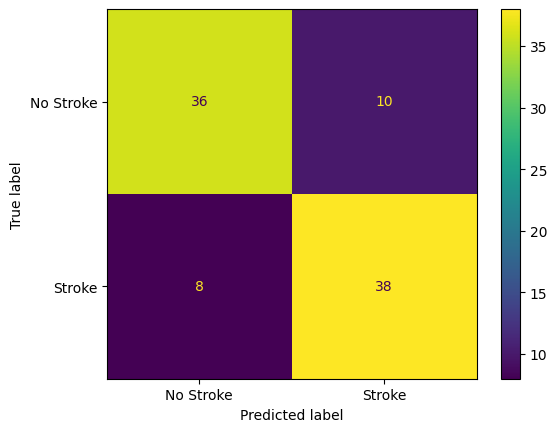

In [29]:
# See how well it worked on the training data
train_pred = pipeline.predict(train[preds])
cm = confusion_matrix(is_stroke, train_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"])
disp.plot()

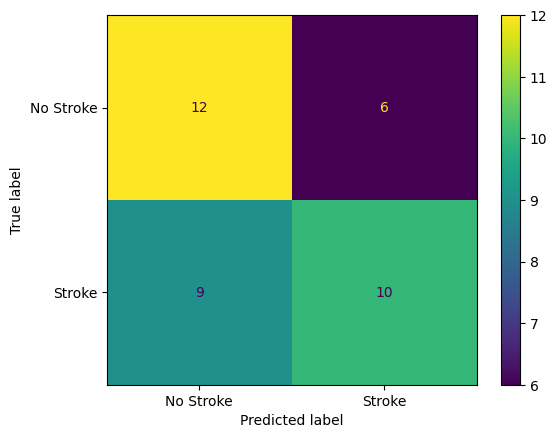

In [ ]:
# How does it do on our held-back test set?
# BAD BAD BAD
# Note: skipped a bunch of steps, we shouldn't be looking at test yet!
test_pred = pipeline.predict(test[preds])
cm = confusion_matrix(test["Stroke"] == "Y", test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"])
disp.plot()